In [2]:
#IMPORTS

import re
import csv
import pandas
import nltk
from nltk.corpus import stopwords 
from itertools import islice
from textblob import Word
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
import pickle
import string
from sklearn import svm,neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
#FUNCTIONS

def clean_text(string_in):

    string_in = re.sub(r"@\w+", "", string_in) # Remove twitter handle
    #string_in = re.sub(r"\#\w+", "", string_in) # Remove hashtags ???
    string_in = re.sub(r"\d", "", string_in)   # Remove numbers
    string_in = re.sub(r"_+", "", string_in)   # Remove consecutive underscores
    string_in = string_in.lower()              # Tranform to lower case
    string_in = re.sub(r'http\S+', '', string_in) # Remove links
    string_in = re.sub(r'[^\w\s]','',string_in) # Remove punctuation

    return string_in.strip()


def wordCloudDraw(my_list,idNum):

    word_could_dict=Counter(my_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    filename = 'plots_{}.png'.format(idNum)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()


def tokenizeDocs(X):
	transformed_X = []
	for document in X:
		tokenized_doc = []
		for sent in nltk.sent_tokenize(document):
			tokenized_doc += nltk.word_tokenize(sent)
		transformed_X.append(np.array(tokenized_doc))
	return np.array(transformed_X)


def searchLex(filename,word):

	with open(filename) as f:
		datafile = f.readlines()
	for line in datafile:
		if word in line:
			res = line.partition("\t")[2]
			return string.atof(res.rstrip())
	return 0.0

In [4]:
####          MAIN          ####

# Read Files

#number of lines in the file
numlineTest = 12284
numlineTrain = 24979


#Training File
with open('../twitter_data/train2017.tsv') as tsvfile:
	reader = csv.reader(tsvfile, delimiter='\t')
	head = list(islice(reader,numlineTrain))

tsvfile.close()

#Test File
with open('../twitter_data/test2017.tsv') as tsvfile1:
 	reader1 = csv.reader(tsvfile1, delimiter='\t')
 	head1 = list(islice(reader1,numlineTest))

tsvfile1.close()

#Test Evaluation File
f = open("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", "r")   
data = [i.strip('\n').split('\t') for i in open("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", "r")]

testEvaluation = []
for k in range(0,len(data)):
    testEvaluation.append(data[k][1])


textTest = []
#Test Data
for k in range(0,numlineTest):
	textTest.append(clean_text(head1[k][3]))

#Training Data

#Data clearance
text = []
polarity = []
idArr = []
for k in range(0,numlineTrain):
	text.append(clean_text(head[k][3]))
	idArr.append(head[k][0])
	polarity.append(head[k][2])


#Tokenization
textTokenized = []
testTextTokenized = []
for k in range(0,numlineTrain):
	textTokenized.append(nltk.word_tokenize(text[k]))
for k in range(0,numlineTest):
	testTextTokenized.append(nltk.word_tokenize(textTest[k]))

#Stop words filtering
stop_words = set(stopwords.words('english'))
ftext = []
ftextTest = []
for k in range(0,numlineTrain):
	ftext.append([word for word in textTokenized[k] if word not in stop_words])
for k in range(0,numlineTest):
    ftextTest.append([word for word in testTextTokenized[k] if word not in stop_words])

#Stemming -> Lemmatization
stext = []
stextTest = []
WNlemma = nltk.WordNetLemmatizer()
for k in range(0,numlineTrain):
	stext.append([WNlemma.lemmatize(t, pos = 'v') for t in ftext[k]])
for k in range(0,numlineTest):
    stextTest.append([WNlemma.lemmatize(t, pos = 'v') for t in ftextTest[k]])


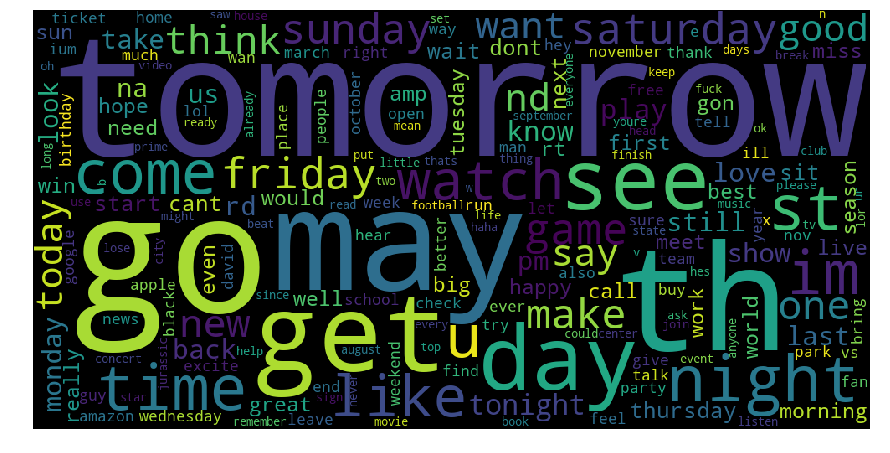

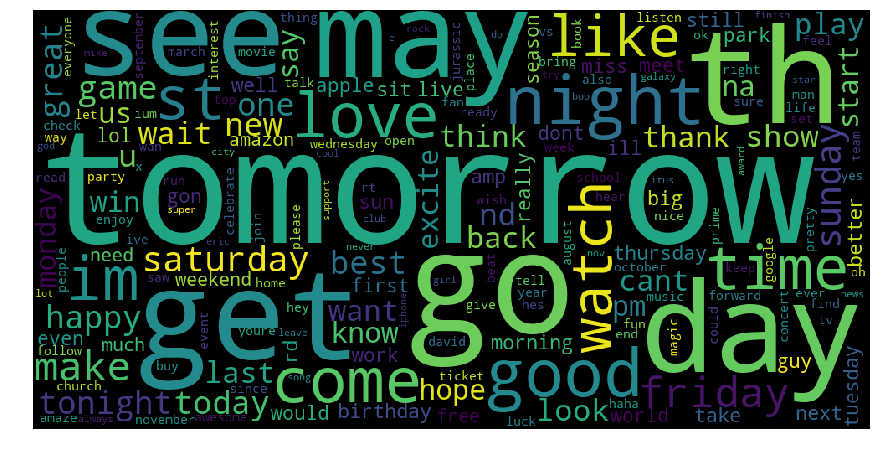

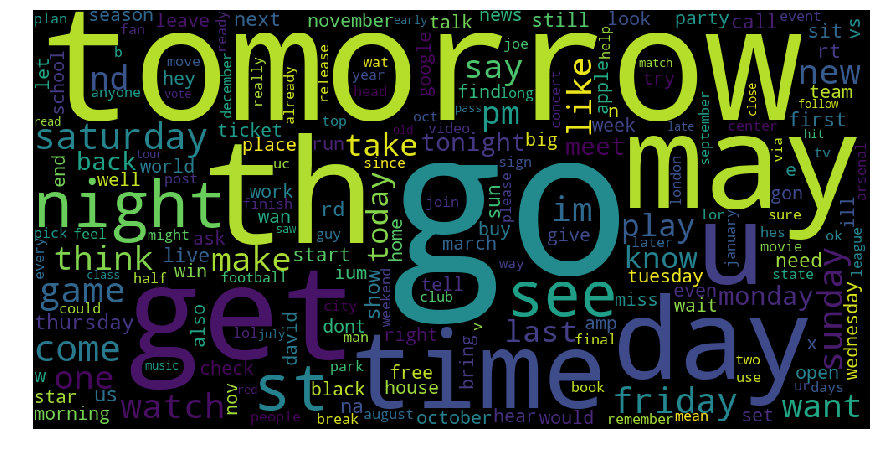

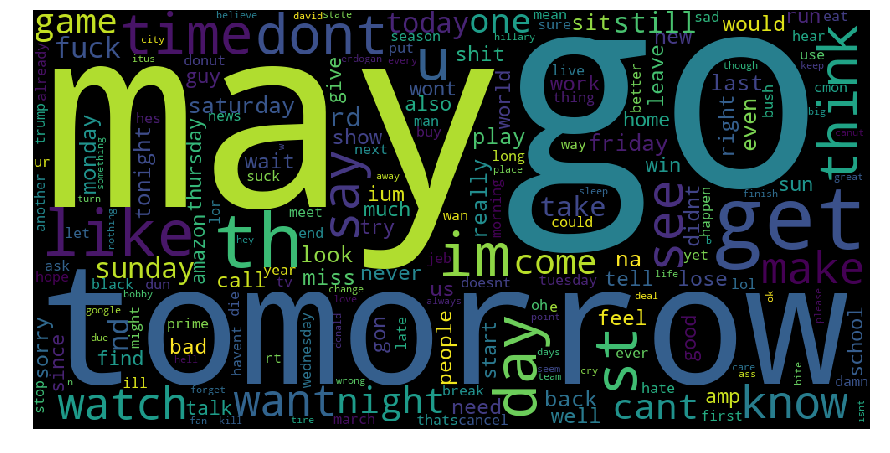

In [5]:
#Data Analysis

#1.Most used words
resAT = []
resPT = []
resNT = []
resNGT = []

#a. In the set of the tweets
resAT = [item for sublist in stext for item in sublist]

for k in range(0,numlineTrain):
    for sublist in stext[k]:
    #b. In the positive tweets
        if polarity[k] == 'positive':
            resPT.append(sublist)
    #c. In the neutral tweets
        elif polarity[k] == 'neutral':
            resNT.append(sublist)
    #d. In the negative tweets
        elif polarity[k] == 'negative':
            resNGT.append(sublist)

wordCloudDraw(resAT,0)
wordCloudDraw(resPT,1)
wordCloudDraw(resNT,2)
wordCloudDraw(resNGT,3)


In [6]:
# Bag-Of-Words

# For training data

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(text)
#print bow_xtrain
#print bow_vectorizer.vocabulary_.get("tomorrow")

# For test data

bow_vectorizer1 = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow1 = bow_vectorizer1.fit_transform(textTest)
#print bow_xtrain1
#print bow_vectorizer1.vocabulary_.get("tomorrow")

In [7]:
# Tf/Idf

# For training data

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text)
#print tfidf
#print tfidf_vectorizer.vocabulary_.get("tomorrow")

# For test data

tfidf_vectorizer1 = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf1 = tfidf_vectorizer1.fit_transform(textTest)
#print tfidf1
#print tfidf_vectorizer1.vocabulary_.get("tomorrow")


In [8]:
# Embeddings

filename1 = 'finalized_Train_model.pkl'
filename2 = 'finalized_Test_model.pkl'

model_w2v = Word2Vec(stext, size=250, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v.train(stext, total_examples= numlineTrain, epochs=20)

model_w2v1 = Word2Vec(stextTest, size=250, window=5, min_count=2, sg = 1, hs = 0, negative = 10, workers= 2, seed = 34)
model_w2v1.train(stextTest, total_examples= numlineTest, epochs=20)

# save the models to disk
pickle.dump(model_w2v, open(filename1, 'wb'))
pickle.dump(model_w2v1, open(filename2, 'wb'))

# load the model from disk
#model_w2v = pickle.load(open(filename1, 'rb'))
#model_w2v1 = pickle.load(open(filename2, 'rb'))

#print model_w2v.most_similar('theo')
#print model_w2v1.most_similar('ariana')


In [9]:
# Finding the mean value of each tweet and adding new features

dim = len(model_w2v.wv.syn0[0])
Xtemp = tokenizeDocs(text)

dimTest = len(model_w2v1.wv.syn0[0])
Xtest = tokenizeDocs(textTest)

mean_embedded = np.array([np.mean([model_w2v.wv[w] for w in words
 if w in model_w2v.wv] or [np.zeros(dim)], axis=0) for words in Xtemp])

mean_embedded1 = np.array([np.mean([model_w2v1.wv[w] for w in words
 if w in model_w2v1.wv] or [np.zeros(dim)], axis=0) for words in Xtest])

############################### calls for the rest of the dictionaries ###############################

# searchLex('../lexica/emotweet/valence_tweet.txt',word)
# searchLex('../lexica/generic/generic.txt',word)
# searchLex('../lexica/nrc/val.txt',word)
# searchLex('../lexica/nrctag/val.txt',word)
######################################################################################################

alist = np.array(mean_embedded).tolist()
k = 0
for words in Xtemp:
	value = 0
	wordCount = 0
	for w in words:
		value = value + searchLex('../lexica/affin/affin.txt',w)
		wordCount = wordCount + 1
	if wordCount == 0:
		meanVal = 0.0
	else:
		meanVal = value / wordCount
	alist[k].append(meanVal)
	alist[k].append(wordCount)
	k = k + 1

w2vector = np.array(alist)

alist1 = np.array(mean_embedded1).tolist()
k = 0
for words in Xtest:
	value = 0
	wordCount = 0
	for w in words:
		value = value + searchLex('../lexica/affin/affin.txt',w)
		wordCount = wordCount + 1
	if wordCount == 0:
		meanVal = 0.0
	else:
		meanVal = value / wordCount
	alist1[k].append(meanVal)
	alist1[k].append(wordCount)
	k = k + 1

w2vector1 = np.array(alist1)


/home/konstantine/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/konstantine/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [10]:
# Classification

#Train Data

#word2vec model : mean_embedded
#word2vec model with new features : w2vector
#bag-of-words model: bow
#tf/idf model: tfidf

# labels: 0 for positive, 1 for neutral, 2 for negative

#DEN MPORW NA TO TREKSW STO NOTEBOOK,ME OLA TA DEDOMENA. MOY EMFANIZEI KAPOIO MEMORY ERROR.TREXEI MONO TO SVM
#STO Spyder TREXEI KANONIKA ANEKSARTHTWS OGKOU DEDOMENON

label = []
for k in range(0,numlineTrain):
	if polarity[k] == 'positive':
		label.append(0)
	elif polarity[k] == 'neutral':
		label.append(1)
	else:
		label.append(2)

xtrain, xvalid, ytrain, yvalid = train_test_split(bow, label, random_state=42, test_size=0.2)

# SVM Classification

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain, ytrain)
prediction = svc.predict(xvalid)
prediction1 = svc.predict(bow1)
print "F1 score for SVM,with training data set is:", f1_score(yvalid, prediction,average='macro', labels=np.unique(prediction))
print "Accuracy for SVM,with training data set is:", accuracy_score(yvalid,prediction)*100

#KNN Classification

for K in range(2,25):
	K_value = K+1
	neigh = neighbors.KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
	neigh = neigh.fit(xtrain, ytrain)
	prediction = neigh.predict(xvalid)
	print "F1 score,with training data set is: ",f1_score(yvalid,prediction,average='macro' , labels=np.unique(prediction)), "for K-Value",K_value
	print "Accuracy,with training data set is: ", accuracy_score(yvalid,prediction)*100,"% for K-Value:",K_value


F1 score for SVM,with training data set is: 0.5825725659743494
Accuracy for SVM,with training data set is: 65.0720576461169


MemoryError: 

In [1]:
#Test Data

#word2vec model : mean_embedded1
#word2vec model with new features : w2vector1
#bag-of-words model: bow1
#tf/idf model: tfidf1

# labels: 0 for positive, 1 for neutral, 2 for negative

#DEN MPORW NA TO TREKSW STO NOTEBOOK,ME OLA TA DEDOMENA. MOY EMFANIZEI KAPOIO MEMORY ERROR.TREXEI MONO TO SVM
#STO Spyder TREXEI KANONIKA ANEKSARTHTWS OGKOU DEDOMENON

label = []
for k in range(0,numlineTest):
	if testEvaluation[k] == 'positive':
		label.append(0)
	elif testEvaluation[k] == 'neutral':
		label.append(1)
	else:
		label.append(2)

xtrain, xvalid, ytrain, yvalid = train_test_split(bow1, label, random_state=42, test_size=0.2)

# SVM Classification

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain, ytrain)
prediction = svc.predict(xvalid)
print "F1 score for SVM,with test data set is:", f1_score(yvalid, prediction,average='macro', labels=np.unique(prediction))
print "Accuracy for SVM,with test data set is:", accuracy_score(yvalid,prediction)*100

#KNN Classification

for K in range(2,25):
	K_value = K+1
	neigh = neighbors.KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
	neigh = neigh.fit(xtrain, ytrain)
	prediction = neigh.predict(xvalid)
	print "F1 score,with test data set is: ",f1_score(yvalid,prediction,average='macro' , labels=np.unique(prediction)), "for K-Value",K_value
	print "Accuracy,with test data set is: ", accuracy_score(yvalid,prediction)*100,"% for K-Value:",K_value



NameError: name 'numlineTest' is not defined